In [100]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from collections import Counter
import json
import cv2
import random

In [101]:
import h5py
import numpy as np

ds = h5py.File('../3dshapes.h5', 'r')
print(ds.keys())
images = ds['images'][:]
labels = ds['labels'][:]


<KeysViewHDF5 ['images', 'labels']>


In [102]:
print("Images shape:", images.shape)
print("Images dtype:", images.dtype)
print("Labels shape:", labels.shape)
print("Labels dtype:", labels.dtype)

Images shape: (480000, 64, 64, 3)
Images dtype: uint8
Labels shape: (480000, 6)
Labels dtype: float64


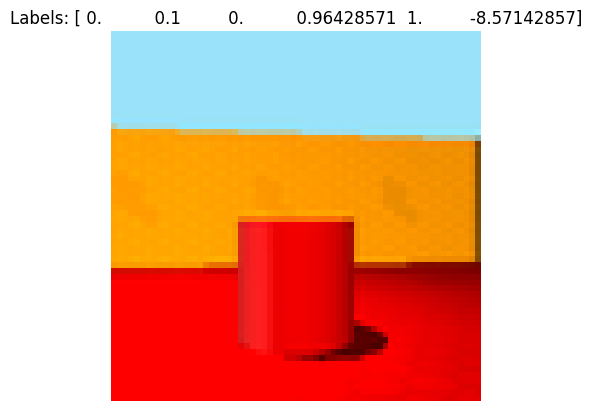

[ 0.          0.1         0.          0.96428571  1.         -8.57142857]


In [103]:
idx = 5000
img = images[idx]
lbl = labels[idx]

plt.imshow(img)
plt.title(f"Labels: {lbl}")
plt.axis('off')
plt.show()

print(lbl)

Number of unique object hues: 10
Unique object hue values:
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Collected indices: {np.float64(0.0): 0, np.float64(0.1): 480, np.float64(0.2): 960, np.float64(0.30000000000000004): 1440, np.float64(0.4): 1920, np.float64(0.5): 2400, np.float64(0.6000000000000001): 2880, np.float64(0.7000000000000001): 3360, np.float64(0.8): 3840, np.float64(0.9): 4320}


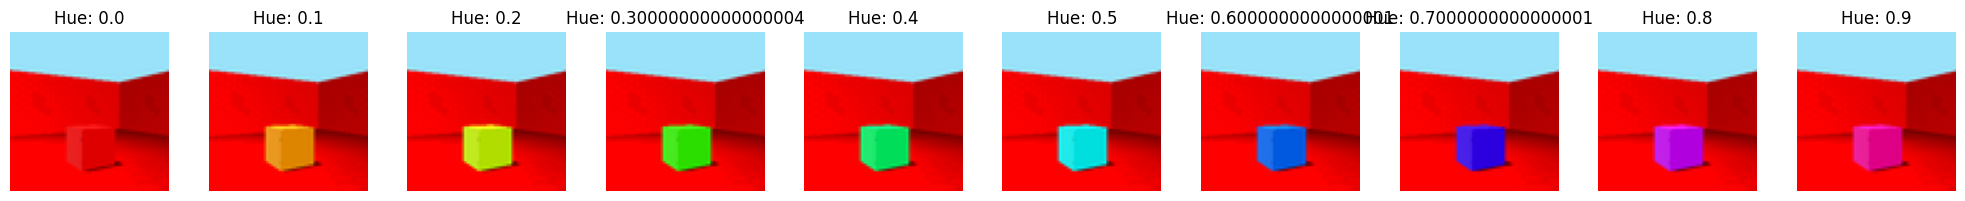

In [ ]:
import numpy as np

object_hues = labels[:, 2]
unique_hues = np.unique(object_hues)

print("Number of unique object hues:", len(unique_hues))
print("Unique object hue values:", unique_hues)

hue_to_index = {}

for i, h in enumerate(object_hues):
    if h not in hue_to_index:
        hue_to_index[h] = i
    if len(hue_to_index) == len(unique_hues):
        break

print("Collected indices:", hue_to_index)

n = len(unique_hues)
fig, axes = plt.subplots(1, n, figsize=(2*n, 2))

if n == 1:
    axes = [axes]

for ax, (hue, idx) in zip(axes, hue_to_index.items()):
    ax.imshow(images[idx])
    ax.set_title(f"Hue: {hue}")
    ax.axis('off')

plt.tight_layout()
plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Kept hues: [np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6000000000000001), np.float64(0.7000000000000001)]
Counter({'green': 144000, 'blue': 144000, 'red': 48000, 'yellow': 48000})


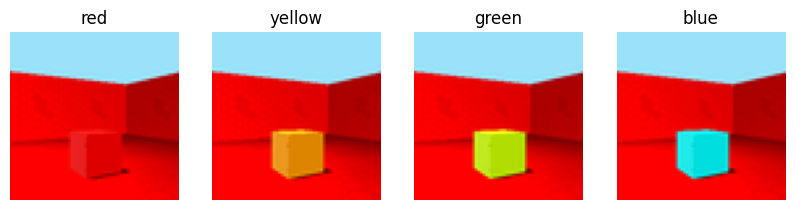

In [105]:
unique_hues = np.unique(labels[:, 2])
print(unique_hues)
sorted_hues = sorted(unique_hues)
kept_hues = sorted_hues[:-2]

print("Kept hues:", kept_hues)

hue_group_map = {
    kept_hues[0]: "red",
    kept_hues[1]: "yellow",
    kept_hues[2]: "green",
    kept_hues[3]: "green",
    kept_hues[4]: "green",
    kept_hues[5]: "blue",
    kept_hues[6]: "blue",
    kept_hues[7]: "blue",
}



mapped_labels = []
for h in labels[:, 2]:
    if h in hue_group_map:
        mapped_labels.append(hue_group_map[h])

print(Counter(mapped_labels))

semantic_examples = {}

for i, h in enumerate(labels[:, 2]):
    if h in hue_group_map:
        color = hue_group_map[h]
        if color not in semantic_examples:
            semantic_examples[color] = i
    if len(semantic_examples) == 4:
        break

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for ax, (color, idx) in zip(axes, semantic_examples.items()):
    ax.imshow(images[idx])
    ax.set_title(color)
    ax.axis('off')

plt.show()



with open("hue_group_map.json", "w") as f:
    json.dump({str(k): v for k, v in hue_group_map.items()}, f, indent=2)


Saturation stats:
Min: 19
Max: 255
Mean: 209.229248046875


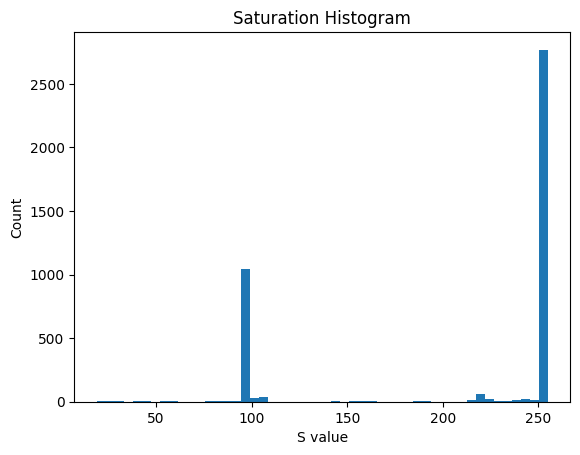

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = images[0]  

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)

print("Saturation stats:")
print("Min:", s.min())
print("Max:", s.max())
print("Mean:", s.mean())

plt.hist(s.flatten(), bins=50)
plt.title("Saturation Histogram")
plt.xlabel("S value")
plt.ylabel("Count")
plt.show()


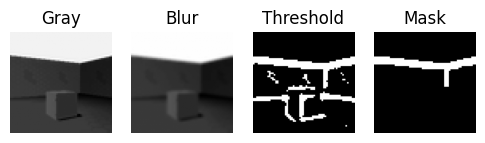

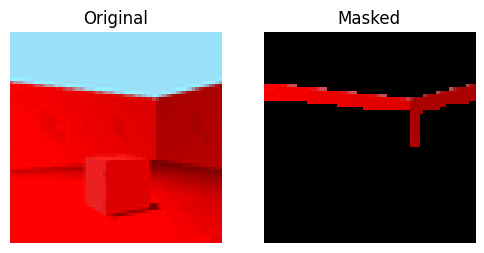

In [107]:
import cv2
import numpy as np

def get_object_mask_contour(img):
    fig, axs = plt.subplots(1,4, figsize=(6,3))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    axs[0].imshow(gray, cmap="gray")
    axs[0].set_title("Gray")
    axs[0].axis('off')
    
    # Light Gaussian blur
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    axs[1].imshow(blur, cmap="gray")
    axs[1].set_title("Blur")
    axs[1].axis('off')
    
    # Adaptive threshold 
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )
    axs[2].imshow(thresh, cmap="gray")
    axs[2].set_title("Threshold")
    axs[2].axis('off')
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    if len(contours) == 0:
        mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        return mask
    
    # Pick largest contour
    cnt = max(contours, key=cv2.contourArea)
    
    # Fill contour to create mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, thickness=-1)
    
    # Morphological cleanup
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    axs[3].imshow(mask, cmap="gray")
    axs[3].set_title("Mask")
    axs[3].axis('off')
    plt.show()
    
    return mask


masked_img = cv2.bitwise_and(img, img, mask=get_object_mask_contour(img))

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(masked_img)
axs[1].set_title("Masked")
axs[1].axis('off')
plt.show()
